### Original source  
https://github.com/LeonardoBerti00/TABL-Temporal-Attention-Augmented-Bilinear-Network-for-Financial-Time-Series-Data-Analysis

### **TABL**

In [14]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [31]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# dec_train.shape = (149, 203800)

h = 2        #if h = 2, than horizon = 50
T = 50      #horizon 
dim = 10
k = T//10    #horizon

#t_offset = 0   # original label
t_offset = k-1 # fixed label. temporal shifted

y_train = dec_train[-h, :].flatten()
# y_train.shape = (203800,)
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

# 10-1: 10 means the length of inputs
# second -1 means [1,2,3] to [0,1,2] conversion of class id
y_train = y_train[dim-1+t_offset:] - 1
#y_train = y_train[dim-1:] - 1
# y_train.shape = (203791,) # 203791 = 203800-(10+1)
y_val = y_val[dim-1+t_offset:] - 1
#y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1+t_offset:] - 1 
#y_test = y_test[dim-1:] - 1 

# First 40 features = 10*4 features
dec_train = dec_train[:40, :].T
# dec_train.shape = (203800, 40)
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

In [32]:
#computing the weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [33]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        #self.length = x.shape[0] - (T/10) -self.dim + 1
        self.length = x.shape[0] - ((T//10)-1) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [34]:
#Hyperparameters
batch_size = 256
epochs = 200
   
lr = 0.01
num_classes = 3
#dim = 10

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

60578
155161
242347


In [35]:
dec_train[0, 0]

0.35983073

In [36]:
for i,(x,y) in enumerate(dataset_train):
    print(x.shape, y.shape)
    n = x.shape[0]
    mids = (x[0, :] + x[2, :])/2
    print(mids)
    break

torch.Size([40, 10]) torch.Size([])
tensor([0.3543, 0.3688, 0.3688, 0.3688, 0.3688, 0.3708, 0.3673, 0.3673, 0.3688,
        0.3673], dtype=torch.float64)


### **Model Architecture**


In [37]:
class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x


class BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))



class CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()
    
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
 
    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))
    

In [38]:
class BiN(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1
        self.d1 = d1
        self.t2 = t2
        self.d2 = d2

        bias1 = torch.Tensor(t1, 1)
        self.B1 = nn.Parameter(bias1)
        nn.init.constant_(self.B1, 0)

        l1 = torch.Tensor(t1, 1)
        self.l1 = nn.Parameter(l1)
        nn.init.xavier_normal_(self.l1)

        bias2 = torch.Tensor(d1, 1)
        self.B2 = nn.Parameter(bias2)
        nn.init.constant_(self.B2, 0)

        l2 = torch.Tensor(d1, 1)
        self.l2 = nn.Parameter(l2)
        nn.init.xavier_normal_(self.l2)

        y1 = torch.Tensor(1, )
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.5)

        y2 = torch.Tensor(1, )
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.5)

    def forward(self, x):

        # if the two scalars are negative then we setting them to 0
        if (self.y1[0] < 0):
            y1 = torch.cuda.FloatTensor(1, )
            self.y1 = nn.Parameter(y1)
            nn.init.constant_(self.y1, 0.01)

        if (self.y2[0] < 0):
            y2 = torch.cuda.FloatTensor(1, )
            self.y2 = nn.Parameter(y2)
            nn.init.constant_(self.y2, 0.01)

        # normalization along the temporal dimensione
        #T2 = torch.ones([self.t1, 1], device=cst.DEVICE_TYPE)
        T2 = torch.ones([self.t1, 1], device=device)
        x2 = torch.mean(x, dim=2)
        x2 = torch.reshape(x2, (x2.shape[0], x2.shape[1], 1))

        std = torch.std(x, dim=2)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))
        # it can be possible that the std of some temporal slices is 0, and this produces inf values, so we have to set them to one
        std[std < 1e-4] = 1

        diff = x - (x2 @ (T2.T))
        Z2 = diff / (std @ (T2.T))

        X2 = self.l2 @ T2.T
        X2 = X2 * Z2
        X2 = X2 + (self.B2 @ T2.T)

        # normalization along the feature dimension
        #T1 = torch.ones([self.d1, 1], device=cst.DEVICE_TYPE)
        T1 = torch.ones([self.d1, 1], device=device)
        x1 = torch.mean(x, dim=1)
        x1 = torch.reshape(x1, (x1.shape[0], x1.shape[1], 1))

        std = torch.std(x, dim=1)
        std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

        op1 = x1 @ T1.T
        op1 = torch.permute(op1, (0, 2, 1))

        op2 = std @ T1.T
        op2 = torch.permute(op2, (0, 2, 1))

        z1 = (x - op1) / (op2)
        X1 = (T1 @ self.l1.T)
        X1 = X1 * z1
        X1 = X1 + (T1 @ self.B1.T)

        # weighing the imporance of temporal and feature normalization
        x = self.y1 * X1 + self.y2 * X2

        return x
        
class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x

class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1 / t1)

        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1, )
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):

        # maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0):
            l = torch.Tensor(1, )
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1):
            l = torch.Tensor(1, )
            self.l = nn.Parameter(l)
            nn.init.constant_(self.l, 1.0)

        # modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        # enforcing constant (1) on the diagonal
        #W = self.W - self.W * torch.eye(self.t1, dtype=torch.float32, device=cst.DEVICE_TYPE) + torch.eye(self.t1, dtype=torch.float32, device=cst.DEVICE_TYPE) / self.t1
        W = self.W - self.W * torch.eye(self.t1, dtype=torch.float32, device=device) + torch.eye(self.t1, dtype=torch.float32, device=device) / self.t1

        # attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        # computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        # applying a soft attention mechanism  (10)
        # he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0]) * X * A

        # the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y


class BiN_CTABL(nn.Module):
    # d2=60, d1=40, t1=10, t2=10, d3=120, t3=5, d4=3, t4=1
    def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
        super().__init__()

        self.BiN = BiN(d2, d1, t1, t2)
        self.BL = BL_layer(d2, d1, t1, t2)
        self.BL2 = BL_layer(d3, d2, t2, t3)
        # d4=3, d3=120, t3=5, t4=1
        self.TABL = TABL_layer(d4, d3, t3, t4)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):

        # x.shape = (32, 40, 10)
        # first of all we pass the input to the BiN layer, then we use the C(TABL) architecture
        #x = torch.permute(x, (0, 2, 1))

        x = self.BiN(x)

        self.max_norm_(self.BL.W1.data)
        self.max_norm_(self.BL.W2.data)
        x = self.BL(x)
        x = self.dropout(x)

        self.max_norm_(self.BL2.W1.data)
        self.max_norm_(self.BL2.W2.data)
        x = self.BL2(x)
        x = self.dropout(x)

        self.max_norm_(self.TABL.W1.data)
        self.max_norm_(self.TABL.W.data)
        self.max_norm_(self.TABL.W2.data)
        x = self.TABL(x)
        # x.shape = (32, 3, 1)
        x = torch.squeeze(x)
        # x.shape = (32, 3)
        x = torch.softmax(x, 1)
        # x.shape = (32, 3)

        return x

    def max_norm_(self, w):
        with torch.no_grad():
            if (torch.linalg.matrix_norm(w) > 10.0):
                norm = torch.linalg.matrix_norm(w)
                desired = torch.clamp(norm, min=0.0, max=10.0)
                w *= (desired / (1e-8 + norm))


### **Model Training**

I implemented the second setting of the experiment

In [41]:
#Choose between B(TABL) and C(TABL)

#model = BTABL(120, 40, 10, 5, 3, 1)
#model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)
#model = BiN_CTABL(60, 40, 10, 10, 120, 5, 3, 1)
model = BiN_CTABL(60, 40, dim, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    SC = [0.005, 0.001, 0.0005, 0.0001]
    i = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print('### debug 22')
            #print(outputs.shape)
            #print(targets.shape)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        if (train_losses[it-1] <= train_loss and i < 4 and it != 0):
              for g in optimizer.param_groups:
                g['lr'] = SC[i]
              i += 1
              

        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, './best_model_CTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

In [42]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

------- List Hyper Parameters -------
epochs   ->   200
learningRate   ->   0.01
horizon    ->     50
batch size   ->    256
Optimizer   ->    Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|▍                                                                            | 1/200 [00:10<35:09, 10.60s/it]

model saved
Epoch 1/200, Train Loss: 1.0169,           Validation Loss: 0.9720, Duration: 0:00:10.601151, Best Val Epoch: 0


  1%|▊                                                                            | 2/200 [00:20<33:24, 10.12s/it]

model saved
Epoch 2/200, Train Loss: 0.9874,           Validation Loss: 0.9647, Duration: 0:00:09.789578, Best Val Epoch: 1


  2%|█▏                                                                           | 3/200 [00:30<33:39, 10.25s/it]

model saved
Epoch 3/200, Train Loss: 0.9814,           Validation Loss: 0.9604, Duration: 0:00:10.401138, Best Val Epoch: 2


  2%|█▌                                                                           | 4/200 [00:40<33:24, 10.23s/it]

model saved
Epoch 4/200, Train Loss: 0.9777,           Validation Loss: 0.9582, Duration: 0:00:10.184590, Best Val Epoch: 3


  2%|█▉                                                                           | 5/200 [00:51<33:00, 10.16s/it]

model saved
Epoch 5/200, Train Loss: 0.9747,           Validation Loss: 0.9573, Duration: 0:00:10.032187, Best Val Epoch: 4


  3%|██▎                                                                          | 6/200 [01:00<32:29, 10.05s/it]

Epoch 6/200, Train Loss: 0.9726,           Validation Loss: 0.9592, Duration: 0:00:09.833035, Best Val Epoch: 4


  4%|██▋                                                                          | 7/200 [01:10<31:37,  9.83s/it]

Epoch 7/200, Train Loss: 0.9703,           Validation Loss: 0.9589, Duration: 0:00:09.383289, Best Val Epoch: 4


  4%|███                                                                          | 8/200 [01:20<31:27,  9.83s/it]

model saved
Epoch 8/200, Train Loss: 0.9684,           Validation Loss: 0.9548, Duration: 0:00:09.837581, Best Val Epoch: 7


  4%|███▍                                                                         | 9/200 [01:30<31:42,  9.96s/it]

Epoch 9/200, Train Loss: 0.9674,           Validation Loss: 0.9558, Duration: 0:00:10.243160, Best Val Epoch: 7


  5%|███▊                                                                        | 10/200 [01:40<31:23,  9.91s/it]

Epoch 10/200, Train Loss: 0.9659,           Validation Loss: 0.9566, Duration: 0:00:09.807918, Best Val Epoch: 7


  6%|████▏                                                                       | 11/200 [01:49<31:06,  9.88s/it]

Epoch 11/200, Train Loss: 0.9641,           Validation Loss: 0.9557, Duration: 0:00:09.789860, Best Val Epoch: 7


  6%|████▌                                                                       | 12/200 [01:59<30:51,  9.85s/it]

Epoch 12/200, Train Loss: 0.9628,           Validation Loss: 0.9578, Duration: 0:00:09.781703, Best Val Epoch: 7


  6%|████▉                                                                       | 13/200 [02:09<30:57,  9.93s/it]

Epoch 13/200, Train Loss: 0.9623,           Validation Loss: 0.9560, Duration: 0:00:10.131873, Best Val Epoch: 7


  7%|█████▎                                                                      | 14/200 [02:19<30:08,  9.72s/it]

Epoch 14/200, Train Loss: 0.9612,           Validation Loss: 0.9561, Duration: 0:00:09.230435, Best Val Epoch: 7


  8%|█████▋                                                                      | 15/200 [02:28<29:47,  9.66s/it]

model saved
Epoch 15/200, Train Loss: 0.9596,           Validation Loss: 0.9545, Duration: 0:00:09.519766, Best Val Epoch: 14


  8%|██████                                                                      | 16/200 [02:38<29:35,  9.65s/it]

Epoch 16/200, Train Loss: 0.9588,           Validation Loss: 0.9548, Duration: 0:00:09.619350, Best Val Epoch: 14


  8%|██████▍                                                                     | 17/200 [02:48<29:41,  9.74s/it]

Epoch 17/200, Train Loss: 0.9582,           Validation Loss: 0.9552, Duration: 0:00:09.942463, Best Val Epoch: 14


  9%|██████▊                                                                     | 18/200 [02:57<29:28,  9.72s/it]

Epoch 18/200, Train Loss: 0.9564,           Validation Loss: 0.9608, Duration: 0:00:09.666208, Best Val Epoch: 14


 10%|███████▏                                                                    | 19/200 [03:07<29:24,  9.75s/it]

Epoch 19/200, Train Loss: 0.9560,           Validation Loss: 0.9571, Duration: 0:00:09.819899, Best Val Epoch: 14


 10%|███████▌                                                                    | 20/200 [03:17<29:33,  9.85s/it]

Epoch 20/200, Train Loss: 0.9548,           Validation Loss: 0.9577, Duration: 0:00:10.098001, Best Val Epoch: 14


 10%|███████▉                                                                    | 21/200 [03:27<29:07,  9.76s/it]

Epoch 21/200, Train Loss: 0.9539,           Validation Loss: 0.9549, Duration: 0:00:09.543338, Best Val Epoch: 14


 11%|████████▎                                                                   | 22/200 [03:37<29:09,  9.83s/it]

Epoch 22/200, Train Loss: 0.9532,           Validation Loss: 0.9549, Duration: 0:00:09.992382, Best Val Epoch: 14


 12%|████████▋                                                                   | 23/200 [03:47<28:56,  9.81s/it]

Epoch 23/200, Train Loss: 0.9521,           Validation Loss: 0.9573, Duration: 0:00:09.765869, Best Val Epoch: 14


 12%|█████████                                                                   | 24/200 [03:56<28:30,  9.72s/it]

Epoch 24/200, Train Loss: 0.9523,           Validation Loss: 0.9594, Duration: 0:00:09.504396, Best Val Epoch: 14


 12%|█████████▌                                                                  | 25/200 [04:06<28:32,  9.78s/it]

Epoch 25/200, Train Loss: 0.9693,           Validation Loss: 0.9639, Duration: 0:00:09.931176, Best Val Epoch: 14


 13%|█████████▉                                                                  | 26/200 [04:16<28:18,  9.76s/it]

model saved
Epoch 26/200, Train Loss: 0.9579,           Validation Loss: 0.9539, Duration: 0:00:09.717373, Best Val Epoch: 25


 14%|██████████▎                                                                 | 27/200 [04:26<28:34,  9.91s/it]

model saved
Epoch 27/200, Train Loss: 0.9545,           Validation Loss: 0.9539, Duration: 0:00:10.255000, Best Val Epoch: 26


 14%|██████████▋                                                                 | 28/200 [04:36<28:21,  9.89s/it]

Epoch 28/200, Train Loss: 0.9519,           Validation Loss: 0.9558, Duration: 0:00:09.842824, Best Val Epoch: 26


 14%|███████████                                                                 | 29/200 [04:45<27:48,  9.76s/it]

Epoch 29/200, Train Loss: 0.9507,           Validation Loss: 0.9558, Duration: 0:00:09.447645, Best Val Epoch: 26


 15%|███████████▍                                                                | 30/200 [04:55<27:20,  9.65s/it]

Epoch 30/200, Train Loss: 0.9490,           Validation Loss: 0.9582, Duration: 0:00:09.400327, Best Val Epoch: 26


 16%|███████████▊                                                                | 31/200 [05:05<27:36,  9.80s/it]

Epoch 31/200, Train Loss: 0.9487,           Validation Loss: 0.9556, Duration: 0:00:10.153701, Best Val Epoch: 26


 16%|████████████▏                                                               | 32/200 [05:15<27:36,  9.86s/it]

Epoch 32/200, Train Loss: 0.9478,           Validation Loss: 0.9560, Duration: 0:00:09.990927, Best Val Epoch: 26


 16%|████████████▌                                                               | 33/200 [05:25<27:44,  9.97s/it]

Epoch 33/200, Train Loss: 0.9473,           Validation Loss: 0.9564, Duration: 0:00:10.225369, Best Val Epoch: 26


 17%|████████████▉                                                               | 34/200 [05:35<27:21,  9.89s/it]

Epoch 34/200, Train Loss: 0.9466,           Validation Loss: 0.9578, Duration: 0:00:09.690686, Best Val Epoch: 26


 18%|█████████████▎                                                              | 35/200 [05:45<27:21,  9.95s/it]

Epoch 35/200, Train Loss: 0.9453,           Validation Loss: 0.9570, Duration: 0:00:10.088783, Best Val Epoch: 26


 18%|█████████████▋                                                              | 36/200 [05:54<26:59,  9.87s/it]

Epoch 36/200, Train Loss: 0.9448,           Validation Loss: 0.9568, Duration: 0:00:09.697988, Best Val Epoch: 26


 18%|██████████████                                                              | 37/200 [06:04<26:32,  9.77s/it]

Epoch 37/200, Train Loss: 0.9443,           Validation Loss: 0.9586, Duration: 0:00:09.530799, Best Val Epoch: 26


 19%|██████████████▍                                                             | 38/200 [06:14<26:23,  9.77s/it]

Epoch 38/200, Train Loss: 0.9437,           Validation Loss: 0.9568, Duration: 0:00:09.782366, Best Val Epoch: 26


 20%|██████████████▊                                                             | 39/200 [06:24<26:17,  9.80s/it]

Epoch 39/200, Train Loss: 0.9433,           Validation Loss: 0.9582, Duration: 0:00:09.848545, Best Val Epoch: 26


 20%|███████████████▏                                                            | 40/200 [06:33<26:09,  9.81s/it]

Epoch 40/200, Train Loss: 0.9432,           Validation Loss: 0.9575, Duration: 0:00:09.837070, Best Val Epoch: 26


 20%|███████████████▌                                                            | 41/200 [06:43<26:08,  9.86s/it]

Epoch 41/200, Train Loss: 0.9433,           Validation Loss: 0.9572, Duration: 0:00:09.989352, Best Val Epoch: 26


 21%|███████████████▉                                                            | 42/200 [06:53<25:49,  9.81s/it]

Epoch 42/200, Train Loss: 0.9376,           Validation Loss: 0.9576, Duration: 0:00:09.679310, Best Val Epoch: 26


 22%|████████████████▎                                                           | 43/200 [07:02<25:13,  9.64s/it]

Epoch 43/200, Train Loss: 0.9362,           Validation Loss: 0.9585, Duration: 0:00:09.253988, Best Val Epoch: 26


 22%|████████████████▋                                                           | 44/200 [07:12<25:16,  9.72s/it]

Epoch 44/200, Train Loss: 0.9360,           Validation Loss: 0.9583, Duration: 0:00:09.894113, Best Val Epoch: 26


 22%|█████████████████                                                           | 45/200 [07:23<25:39,  9.93s/it]

Epoch 45/200, Train Loss: 0.9358,           Validation Loss: 0.9605, Duration: 0:00:10.424087, Best Val Epoch: 26


 23%|█████████████████▍                                                          | 46/200 [07:33<25:46, 10.04s/it]

Epoch 46/200, Train Loss: 0.9351,           Validation Loss: 0.9602, Duration: 0:00:10.311267, Best Val Epoch: 26


 24%|█████████████████▊                                                          | 47/200 [07:43<25:29, 10.00s/it]

Epoch 47/200, Train Loss: 0.9348,           Validation Loss: 0.9591, Duration: 0:00:09.889573, Best Val Epoch: 26


 24%|██████████████████▏                                                         | 48/200 [07:53<25:19, 10.00s/it]

Epoch 48/200, Train Loss: 0.9348,           Validation Loss: 0.9595, Duration: 0:00:09.993209, Best Val Epoch: 26


 24%|██████████████████▌                                                         | 49/200 [08:02<24:49,  9.86s/it]

Epoch 49/200, Train Loss: 0.9345,           Validation Loss: 0.9625, Duration: 0:00:09.551355, Best Val Epoch: 26


 25%|███████████████████                                                         | 50/200 [08:13<24:49,  9.93s/it]

Epoch 50/200, Train Loss: 0.9341,           Validation Loss: 0.9609, Duration: 0:00:10.079981, Best Val Epoch: 26


 26%|███████████████████▍                                                        | 51/200 [08:23<24:39,  9.93s/it]

Epoch 51/200, Train Loss: 0.9342,           Validation Loss: 0.9626, Duration: 0:00:09.937481, Best Val Epoch: 26


 26%|███████████████████▊                                                        | 52/200 [08:33<24:32,  9.95s/it]

Epoch 52/200, Train Loss: 0.9297,           Validation Loss: 0.9601, Duration: 0:00:09.992483, Best Val Epoch: 26


 26%|████████████████████▏                                                       | 53/200 [08:43<24:33, 10.02s/it]

Epoch 53/200, Train Loss: 0.9292,           Validation Loss: 0.9600, Duration: 0:00:10.196695, Best Val Epoch: 26


 27%|████████████████████▌                                                       | 54/200 [08:53<24:17,  9.98s/it]

Epoch 54/200, Train Loss: 0.9284,           Validation Loss: 0.9601, Duration: 0:00:09.880889, Best Val Epoch: 26


 28%|████████████████████▉                                                       | 55/200 [09:02<23:58,  9.92s/it]

Epoch 55/200, Train Loss: 0.9279,           Validation Loss: 0.9602, Duration: 0:00:09.768404, Best Val Epoch: 26


 28%|█████████████████████▎                                                      | 56/200 [09:12<23:17,  9.71s/it]

Epoch 56/200, Train Loss: 0.9278,           Validation Loss: 0.9602, Duration: 0:00:09.211912, Best Val Epoch: 26


 28%|█████████████████████▋                                                      | 57/200 [09:21<23:07,  9.71s/it]

Epoch 57/200, Train Loss: 0.9278,           Validation Loss: 0.9606, Duration: 0:00:09.703049, Best Val Epoch: 26


 29%|██████████████████████                                                      | 58/200 [09:31<22:56,  9.70s/it]

Epoch 58/200, Train Loss: 0.9276,           Validation Loss: 0.9604, Duration: 0:00:09.672160, Best Val Epoch: 26


 29%|██████████████████████                                                      | 58/200 [09:36<23:31,  9.94s/it]


KeyboardInterrupt: 

### **Model Testing**

In [43]:
model = torch.load('./best_model_CTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for i, (inputs, targets) in enumerate(test_loader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    #print(outputs)
    #print(predictions)
    #print(targets)
    #print((predictions == targets).sum().item(), targets.shape[0])

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.5230


accuracy_score: 0.5230309162740637
              precision    recall  f1-score   support

           0     0.3972    0.6654    0.4975     42515
           1     0.6705    0.5999    0.6332     73156
           2     0.4857    0.2275    0.3098     39490

    accuracy                         0.5230    155161
   macro avg     0.5178    0.4976    0.4802    155161
weighted avg     0.5486    0.5230    0.5137    155161



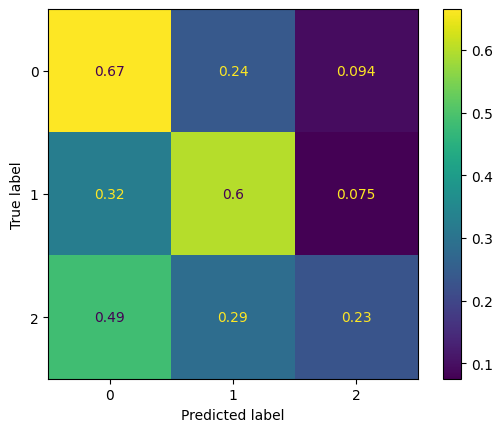

In [44]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [53]:
from sklearn.metrics import f1_score

print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print('f1_score_w:', f1_score(all_targets, all_predictions, average='weighted'))

print()
print(classification_report(all_targets, all_predictions, digits=4))



accuracy_score: 0.5230309162740637
f1_score_w: 0.5137096176234173

              precision    recall  f1-score   support

           0     0.3972    0.6654    0.4975     42515
           1     0.6705    0.5999    0.6332     73156
           2     0.4857    0.2275    0.3098     39490

    accuracy                         0.5230    155161
   macro avg     0.5178    0.4976    0.4802    155161
weighted avg     0.5486    0.5230    0.5137    155161



In [79]:
import re
s = str(c.tolist())
np.fromstring(', '.join(re.findall(r'\[+(.+?)\]', s)), sep =', ').reshape((-1, 3))

array([[0.66536517, 0.24055039, 0.09408444],
       [0.32479906, 0.5998551 , 0.07534584],
       [0.48538871, 0.28713598, 0.22747531]])